In [55]:
MAP_ID = 703368
#MAP_ID = 703326
#MAP_ID = 703323
MIN_THRESHOLD = 0.92

In [56]:
# Carica una mappa da un file JSON e una mappa binaria che rappresenta la camminabilità della mappa, 
# associando i dati letti alla struttura Map definita nel modulo models.

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import json
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from models import Map
sys.path.remove(parent_dir)

with open( "data/maps.json", "r", encoding='utf-8') as f:
    data: dict = json.load(f)
    maps: dict[int, Map] = dict()
    for m in data:
        maps[m["id"]] = Map.from_dict(m)

with open(f"data/walkable-{MAP_ID}.bin", "rb") as bin:
    walkable_image_bytes = bin.read()
    maps[MAP_ID].walkable_image_bytes = walkable_image_bytes

In [57]:
#La funzione restituisce la matrice finale, dove ogni elemento è 1 se il pixel è camminabile, 0 altrimenti.
def create_walkable_matrix(map: Map) -> list[list[float]]:
        walkable_matrix = []
        for y in range(map.height):
            row = []
            for x in range(map.width):
                if map.pixel_is_walkable(x, y):
                    row.append(1)
                else:
                    row.append(0)
            walkable_matrix.append(row)
        return walkable_matrix

walkable_matrix = create_walkable_matrix(maps[MAP_ID])

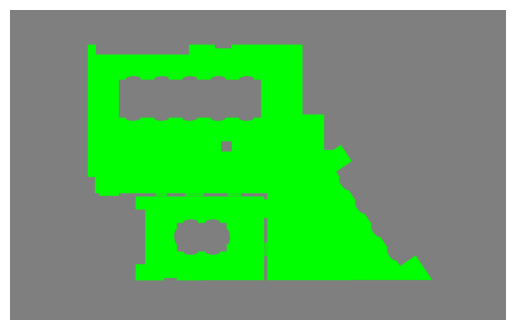

In [58]:

#La funzione show_initial_map serve per visualizzare graficamente la mappa, evidenziando le aree camminabili e non camminabili in modo colorato.
def show_initial_map(map: Map, walkable_matrix: list[list[float]]):

    height = map.height
    width = map.width

    img = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            if walkable_matrix[i][j] == 0:
                img[i][j] = [0.5, 0.5, 0.5]
            else:
                img[i][j] = [1 - walkable_matrix[i][j], walkable_matrix[i][j], 0]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_initial_map(maps[MAP_ID], walkable_matrix)

In [59]:
#La funzione compute_horizontal_ratio calcola una mappa di valori orizzontali “sfumati” per le zone camminabili, assegnando ad ogni punto un valore che dipende dalla distanza dal centro di una sequenza continua di pixel camminabili lungo la riga.
#Serve per dare più peso ai punti centrali delle aree camminabili orizzontali.

def compute_horizontal_ratio(walkable_matrix: list[list[float]], tqdm_title: str):
    result = np.zeros_like(walkable_matrix, dtype=float)
    
    for row_index in tqdm(range(len(walkable_matrix)), desc=tqdm_title):
        start_idx = None
        end_idx = None
        
        for i, val in enumerate(walkable_matrix[row_index]):
            if val == 0:
                if start_idx is not None:
                    end_idx = i
                    center_idx = (start_idx + end_idx) // 2
                    
                    for j in range(start_idx, end_idx):
                        distance = abs(j - center_idx)
                        value = 1 - (distance / (end_idx - start_idx))
                        result[row_index][j] = value
                    
                start_idx = None
                end_idx = None
            elif start_idx is None:
                start_idx = i
    
    return result

Computing horizontal ratio: 100%|██████████| 1563/1563 [00:00<00:00, 2764.94it/s]


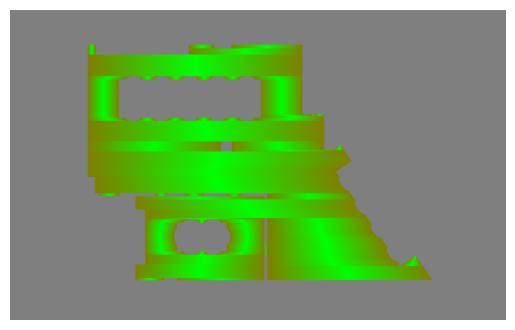

In [60]:
#Questa nuova matrice non è più binaria (0/1), ma contiene valori float tra 0 e 1, dove:

#1 rappresenta i pixel al centro di un corridoio camminabile orizzontale;

#valori minori indicano pixel vicini ai bordi del corridoio;

#0 per i pixel non camminabili.

horizontal_wall_ratio_matrix = compute_horizontal_ratio(walkable_matrix, "Computing horizontal ratio")
show_initial_map(maps[MAP_ID], horizontal_wall_ratio_matrix)

Computing vertical ratio: 100%|██████████| 2500/2500 [00:00<00:00, 4224.55it/s]


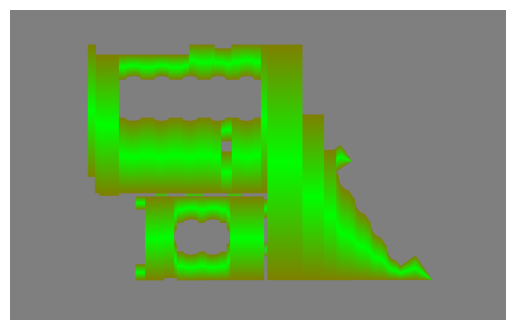

In [61]:
#Questa operazione ruota la matrice, scambiando righe con colonne.

#In pratica, la direzione verticale diventa orizzontale, così puoi riutilizzare compute_horizontal_ratio come se stessi scansionando righe verticali.

#Risultato:
# Grigio dove non si può camminare.
# Verde acceso al centro dei corridoi verticali.
# Tonalità più scure verso i bordi verticali.

walkable_matrix_transposed = list(map(list, zip(*walkable_matrix)))
vertical_wall_ratio_matrix = compute_horizontal_ratio(walkable_matrix_transposed, "Computing vertical ratio")
vertical_wall_ratio_matrix = list(map(list, zip(*vertical_wall_ratio_matrix)))
show_initial_map(maps[MAP_ID], vertical_wall_ratio_matrix)

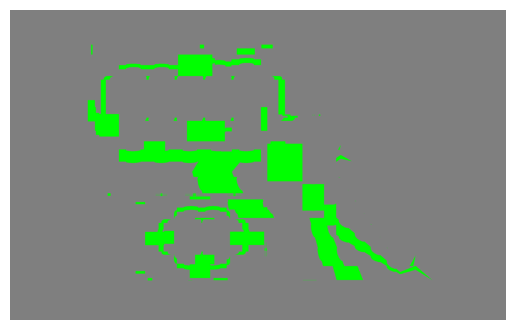

In [62]:
#final_considering_pixel_matrix è una mappa dei punti "centrali abbastanza" — quelli che si trovano dentro corridoi, non troppo vicini ai muri.
def compute_final_matrix(horizontal_wall_ratio_matrix, vertical_wall_ratio_matrix, MIN_THRESHOLD):
    matrix = np.zeros_like(horizontal_wall_ratio_matrix)
    for i in range(len(horizontal_wall_ratio_matrix)):
        for j in range(len(horizontal_wall_ratio_matrix[i])):
            if horizontal_wall_ratio_matrix[i][j] < MIN_THRESHOLD and vertical_wall_ratio_matrix[i][j] < MIN_THRESHOLD:
                matrix[i][j] = 0
            else:
                matrix[i][j] = 1
    return matrix

final_considering_pixel_matrix = compute_final_matrix(horizontal_wall_ratio_matrix, vertical_wall_ratio_matrix, MIN_THRESHOLD) 
show_initial_map(maps[MAP_ID], final_considering_pixel_matrix)

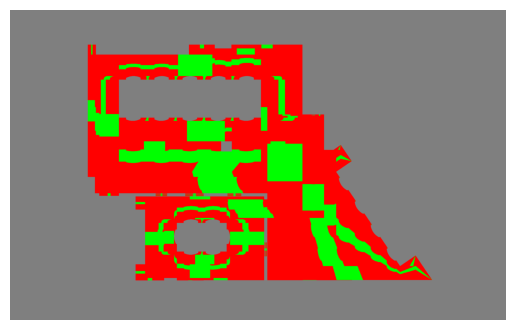

In [63]:
def plot_matrix(map: Map, walkable_matrix, final_considering_pixel_matrix):

    height = map.height
    width = map.width
    img = np.zeros((height, width, 3))

    for i in range(len(walkable_matrix)):
        for j in range(len(walkable_matrix[i])):
            if walkable_matrix[i][j] == 0:
                img[i][j] = [0.5, 0.5, 0.5]
            elif walkable_matrix[i][j] == 1 and final_considering_pixel_matrix[i][j] == 0:
                img[i][j] = [1, 0, 0]
            else:
                img[i][j] = [0, 1, 0]

    # Plot the matrix
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_matrix(maps[MAP_ID], walkable_matrix, final_considering_pixel_matrix)